# Content and Objective

+ Show estimation of acf
+ Method: Get rectangular signal and noise, and perform acf estimation with different normalization factors

In [7]:
# importing
import numpy as np
import scipy.signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [8]:
# plotting options
font = {'size': 30}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(30, 8))


# Estimation of ACF

### Parameters 

In [9]:
# parameters: number of samples and according length of acf
N = int(1e2)
N_acf_range = np.arange(-(N - 1), N, 1)

# number of realizations for averaging
N_real = int(1e2)

# relative width of rectangular and defining rect function
relative_width_rect = 0.3
N_rect = int(N * relative_width_rect)

rect = np.append(np.ones(N_rect), np.zeros(N - N_rect))


### Define Function for Estimating ACF

In [10]:
########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """

    N = np.size(y)
    r = np.zeros_like(y)

    # loop lags of acf
    for k in np.arange(0, N):

        temp = np.sum(y[k:N] * np.conjugate(y[0:(N - k)]))

        # type of estimator
        if est_type == 'biased':
            r[k] = temp / N
        elif est_type == 'unbiased':
            r[k] = temp / (N - k)

    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])

    return np.append(r_reverse[0:len(r) - 1], r)


### Add Noise and Estimate ACF

In [11]:
# initialize arrays for acf estimation
acf_rect_biased = np.zeros(len(N_acf_range))
acf_rect_unbiased = np.zeros(len(N_acf_range))

acf_noise_biased = np.zeros(len(N_acf_range))
acf_noise_unbiased = np.zeros(len(N_acf_range))

# loop for realizations
for _k in range(N_real):

    # rect function and noise only
    rect_noisy = rect + np.random.normal(0.0, 0.2, N)
    noise_only = np.random.normal(0.0, 1.0, N)

    acf_rect_biased = 1. / (_k + 1) * (_k * acf_rect_biased +
                                       est_acf(rect_noisy, 'biased'))
    acf_rect_unbiased = 1. / (_k + 1) * (_k * acf_rect_unbiased +
                                         est_acf(rect_noisy, 'unbiased'))

    acf_noise_biased = 1. / (_k + 1) * (_k * acf_noise_biased +
                                        est_acf(noise_only, 'biased'))
    acf_noise_unbiased = 1. / (_k + 1) * (_k * acf_noise_unbiased +
                                          est_acf(noise_only, 'unbiased'))


### Show Results

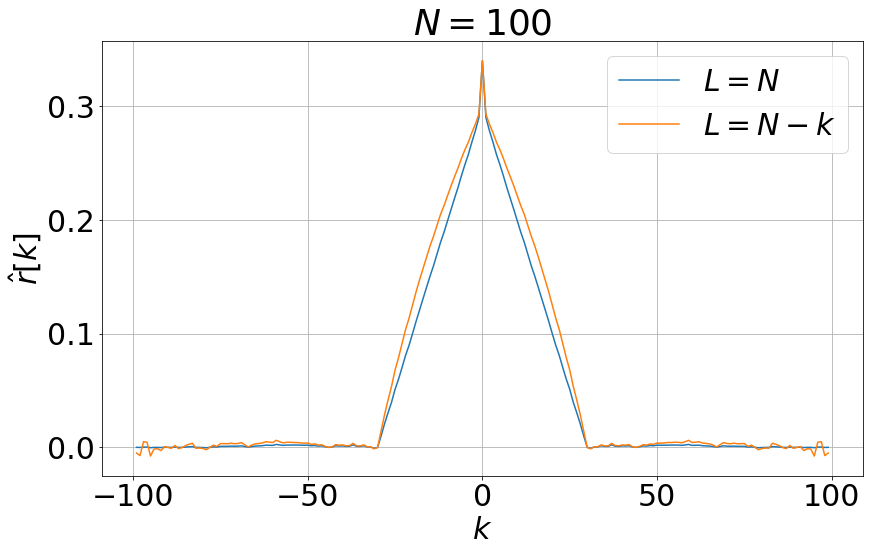

In [12]:
plt.subplot(121)

plt.plot(N_acf_range, acf_rect_biased, label='$L=N$')
plt.plot(N_acf_range, acf_rect_unbiased, label='$L=N-k$')

plt.xlabel('$k$')
plt.ylabel('$\hat{r}[k]$')
plt.grid(True)
plt.title('$N=$' + str(N))
plt.legend(loc='upper right')


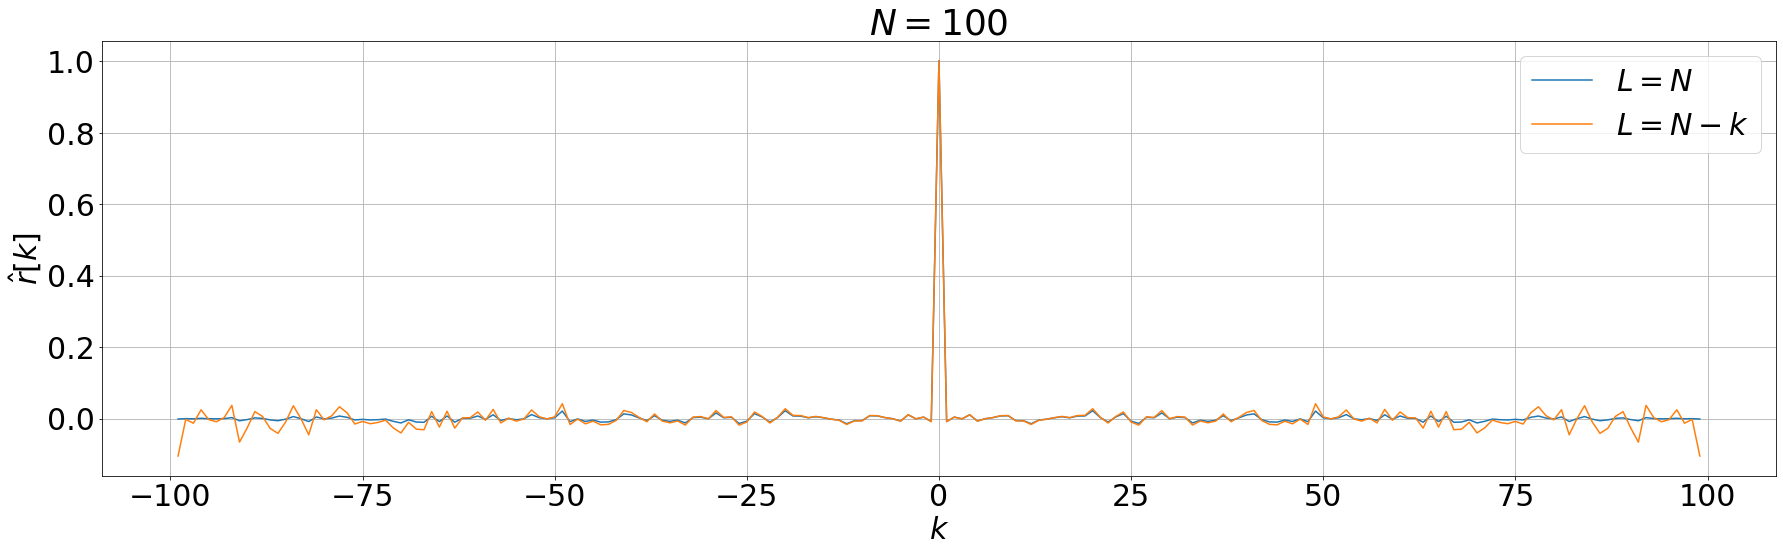

In [13]:
plt.plot(N_acf_range, acf_noise_biased, label='$L=N$')
plt.plot(N_acf_range, acf_noise_unbiased, label='$L=N-k$')

plt.xlabel('$k$')
plt.ylabel('$\hat{r}[k]$')
plt.grid(True)
plt.title('$N=$' + str(N))
plt.legend(loc='upper right')


# Finding Power Spectral Density

### Functions for estimating correlogram out of acf and periodogram

+ Note: The lines directly follow definitions. Practically, FFT would be used

In [14]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex)

    for p in np.arange(0, N):
        per += y[p] * np.exp(-1j * omega * (p + 1))

    per = (abs(per)**2) / N

    return per


########################
# correlogram estimator
########################
def find_correlogram(r, omega):
    """
    estimates correlogram out of the given acf at the frequencies specified in omega
    
    Remark: acf is assumed to be centered around 0
    
    IN: acf r, frequencies
    OUT: psd
    """
    corr = np.zeros(len(omega), dtype=complex)

    N = (len(r) + 1) // 2

    # adding all terms
    for p in np.arange(-(N - 1), (N - 1) + 1):
        corr += r[p + (N - 1)] * np.exp(-1j * omega * p)

    # since there are minor numerical issues, resulting in negligible imaginary part, only real part is returned
    return np.real(corr)


### Parameters

In [15]:
# parameters: number of samples and according length of acf
N = int(1e2)
N_acf_range = np.arange(-N + 1, N, 1)

# number of realizations for averaging
N_real = int(1e2)

# relative width of rectangular and defining rect function
relative_width_rect = 0.1
N_rect = int(N * relative_width_rect)

rect = np.append(np.ones(N_rect), np.zeros(N - N_rect))

# number of freq. points and freq. range
N_freq = 512
Ome = np.linspace(-np.pi, np.pi, N_freq)

### Loop for realizations

In [16]:
# initialize arrays for acf estimation
acf_rect_biased = np.zeros(len(N_acf_range))
acf_rect_unbiased = np.zeros(len(N_acf_range))

acf_noise_biased = np.zeros(len(N_acf_range))
acf_noise_unbiased = np.zeros(len(N_acf_range))

# initialize arrays for psd
psd_rect_per = np.zeros(len(Ome))
psd_rect_cor_biased = np.zeros(len(Ome))
psd_rect_cor_unbiased = np.zeros(len(Ome))

psd_noise_per = np.zeros(len(Ome))
psd_noise_cor_biased = np.zeros(len(Ome))
psd_noise_cor_unbiased = np.zeros(len(Ome))

# loop for realizations
for _k in range(N_real):

    # rect function and noise only
    rect_noisy = rect  #+ np.random.normal(0.0, 0.2, N )
    noise_only = np.random.normal(0.0, 2.0, N)

    acf_rect_biased = est_acf(rect_noisy, 'biased')
    acf_rect_unbiased = est_acf(rect_noisy, 'unbiased')

    acf_noise_biased = est_acf(noise_only, 'biased')
    acf_noise_unbiased = est_acf(noise_only, 'unbiased')

    # find periodogram as well as correlograms
    psd_rect_per = 1. / (_k + 1) * (_k * psd_rect_per +
                                    find_periodogram(rect_noisy, Ome))
    psd_rect_cor_biased = 1. / (_k + 1) * (
        _k * psd_rect_cor_biased + find_correlogram(acf_rect_biased, Ome))
    psd_rect_cor_unbiased = 1. / (_k + 1) * (
        _k * psd_rect_cor_unbiased + find_correlogram(acf_rect_unbiased, Ome))

    psd_noise_per = 1. / (_k + 1) * (_k * psd_noise_per +
                                     find_periodogram(noise_only, Ome))
    psd_noise_cor_biased = 1. / (_k + 1) * (
        _k * psd_noise_cor_biased + find_correlogram(acf_noise_biased, Ome))
    psd_noise_cor_unbiased = 1. / (
        _k + 1) * (_k * psd_noise_cor_unbiased +
                   find_correlogram(acf_noise_unbiased, Ome))


### Plotting

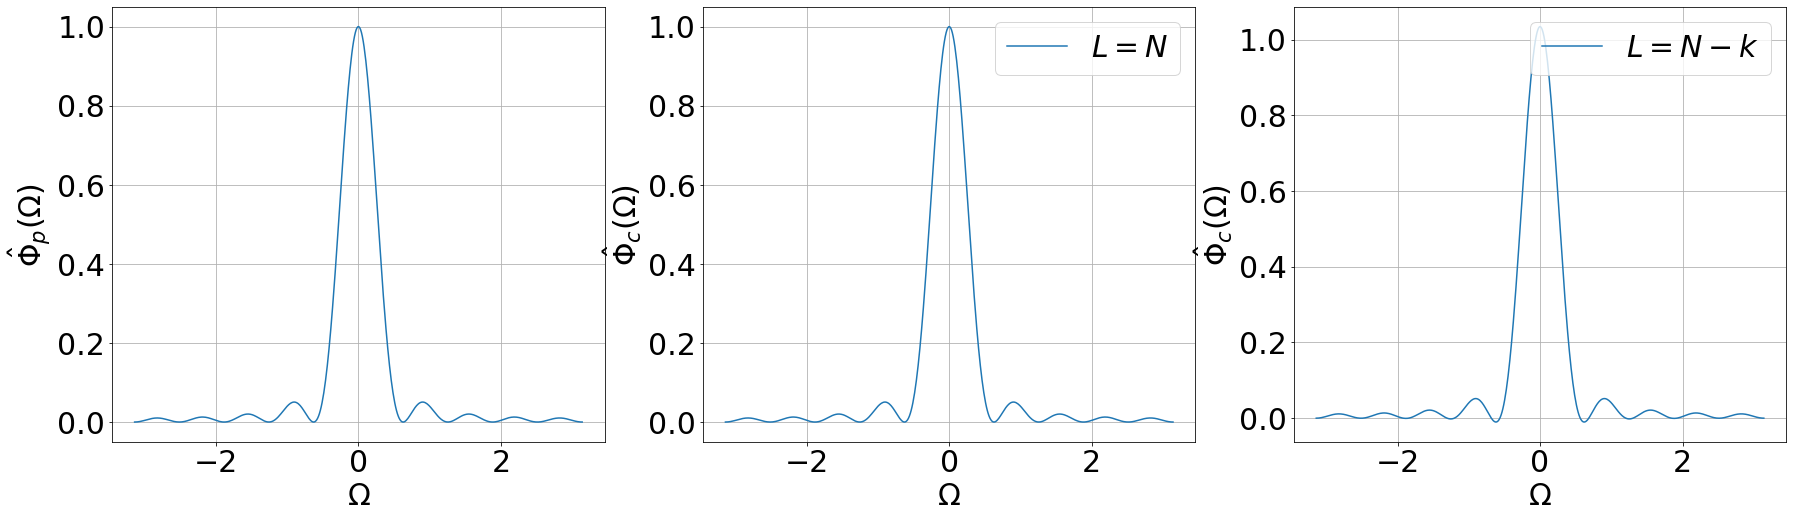

In [17]:
plt.subplot(131)

plt.plot(Ome, psd_rect_per)
plt.grid(True)
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_p(\Omega)$')

plt.subplot(132)
plt.plot(Ome, psd_rect_cor_biased, label='$L=N$')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_c(\Omega)$')

plt.subplot(133)
plt.plot(Ome, psd_rect_cor_unbiased, label='$L=N-k$')
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_c(\Omega)$')
plt.grid(True)
plt.legend(loc='upper right')


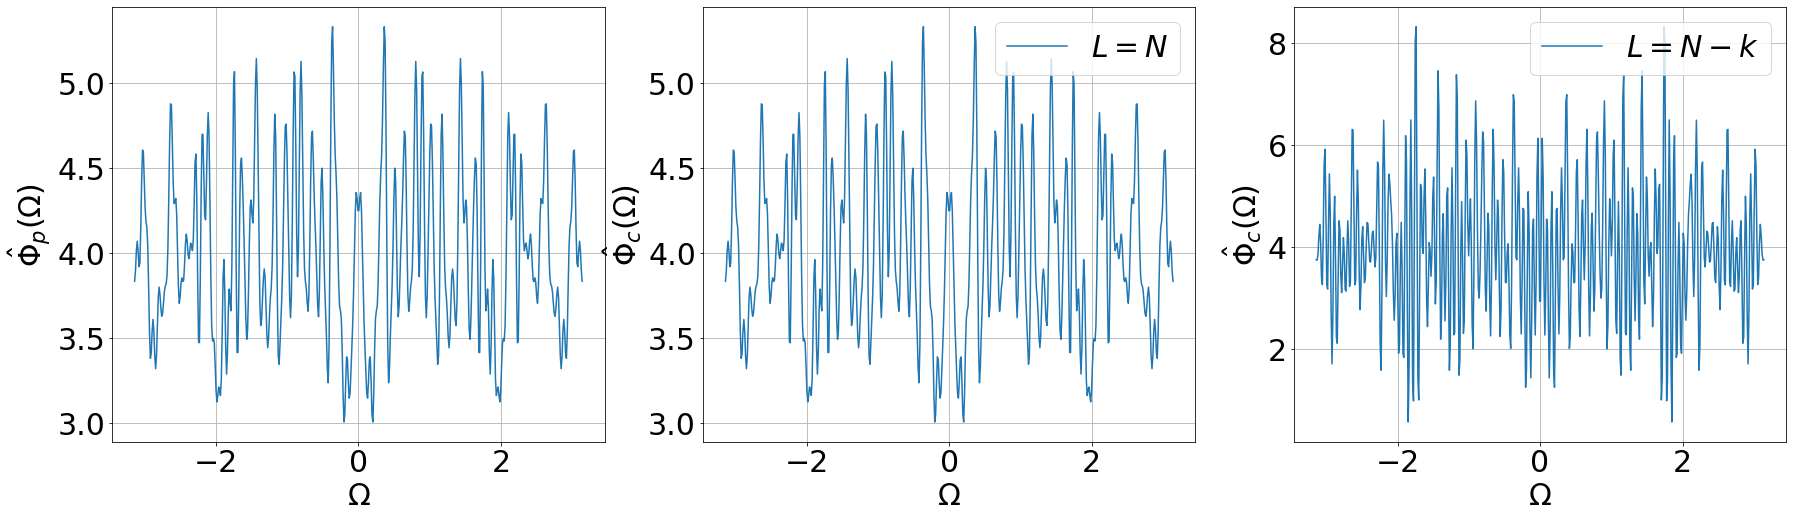

In [18]:
plt.subplot(131)

plt.plot(Ome, psd_noise_per)
#plt.plot(Ome_corr_1, psd_biased_1, label='corr., b')
#plt.title('$N=$'+str(N_1))
plt.grid(True)
#plt.legend(loc='upper right')
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_p(\Omega)$')

plt.subplot(132)
plt.plot(Ome, psd_noise_cor_biased, label='$L=N$')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_c(\Omega)$')

plt.subplot(133)
plt.plot(Ome, psd_noise_cor_unbiased, label='$L=N-k$')
plt.xlabel('$\Omega$')
plt.ylabel('$\hat{\Phi}_c(\Omega)$')
plt.grid(True)
plt.legend(loc='upper right')
